## L11d: Value Iteration for Grid World Navigation
In this lab, you will implement the value iteration algorithm to solve a two-dimensional grid world navigation task where a robot must find the optimal path from any starting position to a charging station while avoiding lava pits. However, like everything in life, there is a backstory.

__Backstory:__ We have a value iteration algorithm that we took from [the Algorithms for Decision Making book](https://algorithmsbook.com/decisionmaking/), which is written by some folks at Stanford University. However, the code is convoluted and hard to follow (we've included it here). Your task is to refactor the value iteration code into a simpler version that is easier to understand and closer to the pseudocode that we discussed in lecture (with a convergence check, clear Bellman update step, etc.). Once you have your refactored version working, you will compare the results to ensure that your implementation produces the same optimal value function as the original.



> __Learning Objectives:__
>
> After completing this activity, students will be able to:
> * **Construct Markov Decision Process (MDP) models for spatial navigation:** We build a 20×20 grid world MDP with states representing grid positions, actions for movement (left, right, up, down), rewards for reaching goals or hazards, and transition dynamics encoding deterministic movement.
> * **Implement value iteration with Bellman updates:** We iteratively compute the optimal value function $U^*(s)$ using the Bellman backup operation, which propagates utility values backward from high-reward states until convergence, enabling optimal decision-making from any state.
> * **Extract optimal policies from value functions:** We derive the optimal policy $\pi^*(s)$ by computing the action-value function $Q(s,a)$ from the converged value function and selecting the action that maximizes expected future reward at each state, then visualize the resulting navigation paths.

This example demonstrates how value iteration solves sequential decision problems by computing optimal policies that balance immediate rewards with long-term consequences. Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include-solution.jl")); # include the Include.jl file

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material.
___

## Task 1: Build the Grid World Model
We encode the rectangular grid world using [the `MyRectangularGridWorldModel` type](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/mdp/#VLDataScienceMachineLearningPackage.MyRectangularGridWorldModel), which represents a spatial environment where a robot must navigate from any starting position to a charging station while avoiding lava pits. 

> __Grid World Structure:__ The model consists of:
> * A 20×20 grid with $(x,y)$ coordinates mapping to discrete states
> * Positive rewards for reaching the charging station (goal)
> * Large negative penalties for lava pits (hazards)
> * Small step costs for regular movements (efficiency incentive)
> * Terminal absorbing states where episodes end (charging station and lava pits)

Let's set up the world parameters by defining the grid dimensions, the number of available actions (left, right, up, down), and the discount factor $\gamma$ that controls how much we value future rewards relative to immediate rewards:

In [ ]:
number_of_rows = 20; # number of rows in the grid world (you can change this)
number_of_cols = 20; # number of cols in the grid world (you can change this)
nactions = 4; # number of actions (LRUD)
γ = 0.05; # discount factor (you can change this)
nstates = (number_of_rows*number_of_cols);
𝒮 = range(1,stop=nstates,step=1) |> collect; # states
𝒜 = range(1,stop=nactions,step=1) |> collect; # actions

What's in the states and actions arrays?

In [3]:
𝒮 

400-element Vector{Int64}:
   1
   2
   3
   4
   5
   6
   7
   8
   9
  10
   ⋮
 392
 393
 394
 395
 396
 397
 398
 399
 400

Next, we define the reward structure by creating the `rewards::Dict{Tuple{Int,Int}, Float64}` dictionary, which maps $(x,y)$ coordinates to reward values. We set the lava pit penalty to $-1000$ for dangerous locations that destroy the robot, while the charging station reward is $+100$ for successfully reaching the goal. We also define an `absorbing_state_set::Set{Tuple{Int,Int}}` containing locations where the episode terminates. Note that we only specify non-default rewards in this dictionary since default step costs will be added later:

In [4]:
# setup rewards -
lava_reward = -1000.0;
charging_reward = 100.0

rewards = Dict{Tuple{Int,Int}, Float64}()
rewards[(1,2)] = lava_reward # lava in the (1,2) square 
rewards[(2,2)] = lava_reward # lava in the (2,2) square 
rewards[(2,3)] = lava_reward # lava in the (2,3) square 
rewards[(4,5)] = lava_reward # lava in the (4,5) square
rewards[(19,20)] = lava_reward # lava in the (19,20) square
rewards[(4,3)] = charging_reward   # charging station square

# setup set of absorbing states -
absorbing_state_set = Set{Tuple{Int,Int}}()
for (k,v) ∈ rewards
    push!(absorbing_state_set, k);   
end

# setup soft walls (constraints) -
soft_wall_set = Set{Tuple{Int,Int}}();

Now we build an instance of [the `MyRectangularGridWorldModel` type](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/mdp/#VLDataScienceMachineLearningPackage.MyRectangularGridWorldModel), which encapsulates the complete grid world environment. We pass the grid dimensions and reward structure to the `build(...)` method, which constructs the `world::MyRectangularGridWorldModel` instance containing the coordinate system (mapping between $(x,y)$ positions and discrete state indices), valid state transitions (moves from each position), and the complete reward function (including default step costs):

In [5]:
world = build(MyRectangularGridWorldModel, 
    (nrows = number_of_rows, ncols = number_of_cols, rewards = rewards));

Let's inspect the world model structure. The `world.moves::Dict{Int,Tuple{Int,Int}}` dictionary maps action indices to movement vectors $\Delta = (\Delta_x, \Delta_y)$, which describe how each action changes the robot's position:

In [6]:
world.moves

Dict{Int64, Tuple{Int64, Int64}} with 4 entries:
  4 => (0, 1)
  2 => (1, 0)
  3 => (0, -1)
  1 => (-1, 0)

___


## Task 2: Construct the MDP Components
To apply value iteration, we need to construct the formal MDP components from our grid world model. 

> __MDP Definition:__ A Markov Decision Process is defined by the tuple $\left(\mathcal{S}, \mathcal{A}, R\left(s, a\right), T\left(s^{\prime}\,|\,s,a\right), \gamma\right)$ where:
> * $\mathcal{S}$ is the state space (all 400 grid positions in our 20×20 grid)
> * $\mathcal{A}$ is the action space (left, right, up, down movements)
> * $R\left(s,a\right)$ is the reward function (immediate rewards for state-action pairs)
> * $T\left(s^{\prime}\,|\,s,a\right)$ is the transition model (probability of reaching $s^{\prime}$ from $s$ via action $a$)
> * $\gamma = 0.95$ is the discount factor (weighting future rewards relative to immediate rewards)

Let's construct these components systematically, starting with the reward function.

### Reward Function $R\left(s,a\right)$
We encode the reward function as an `R::Array{Float64,2}` matrix with dimensions $|\mathcal{S}| \times |\mathcal{A}|$ where entry $R[s,a]$ gives the immediate reward for taking action $a$ from state $s$. 

> __Reward Structure:__ The rewards are assigned as follows:
> * Charging station: $+100$ (goal state)
> * Lava pits: $-1000$ (dangerous states)
> * Regular steps: $-1$ (small cost to encourage efficiency)
> * Out-of-bounds: $-50000$ (large penalty for invalid moves)

For each state-action pair, we compute the resulting position and assign the appropriate reward:

In [7]:
R = let

    # initialize -
    R = zeros(nstates, nactions);
    fill!(R, 0.0)
    
    # For each state-action pair, compute the resulting position and assign rewards
    for s ∈ 𝒮
        for a ∈ 𝒜
        
            # Get the movement vector for this action (e.g., up = (0,1), down = (0,-1))
            Δ = world.moves[a];
            current_position = world.coordinates[s] # Current (x,y) position
            new_position =  current_position .+ Δ   # Resulting (x,y) after taking action a
            
            # Check if the new position is valid (within grid bounds)
            if (haskey(world.states, new_position) == true)
                # Check if there's a special reward at this position (lava or charging station)
                if (haskey(rewards, new_position) == true)
                    R[s,a] = rewards[new_position]; # Assign special reward (+100 or -1000)
                else
                    R[s,a] = -1.0; # Regular step cost (encourages efficiency)
                end
            else
                R[s,a] = -50000.0; # Large penalty for trying to move off the grid
            end
        end
    end
    
    R; # return R
end

400×4 Matrix{Float64}:
 -50000.0      -1.0  -50000.0   -1000.0
 -50000.0   -1000.0      -1.0      -1.0
 -50000.0   -1000.0   -1000.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
      ⋮                        
     -1.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      -1.0      -1.0
  -1000.0  -50000.0      -1.0  -50000.0

### Transition Function $T\left(s^{\prime}\,|\,s,a\right)$
Next, we construct the transition function `T::Array{Float64,3}`, which describes the dynamics of the environment. We encode this as a $|\mathcal{S}| \times |\mathcal{S}| \times |\mathcal{A}|$ array where $T[s, s^{\prime}, a]$ gives the probability of transitioning to state $s^{\prime}$ when taking action $a$ from state $s$. 

> __Deterministic Transitions:__ For our grid world:
> * If action $a$ from state $s$ leads to a valid new position (inside the grid and not from an absorbing state), then $T[s, s^{\prime}, a] = 1$ where $s^{\prime}$ is the resulting state
> * If the action would take us outside the grid or we're already in an absorbing state, then $T[s, s, a] = 1$ (we remain in the current state)

This captures the physics of the world where actions have predictable outcomes:

In [8]:
T = let

    # initialize - 3D array with dimensions |S| x |S| x |A|
    T = Array{Float64,3}(undef, nstates, nstates, nactions);
    fill!(T, 0.0)
    
    # Build transition probabilities for each action
    for a ∈ 𝒜
    
        Δ = world.moves[a]; # Get movement vector for action a
    
        for s ∈ 𝒮
            current_position = world.coordinates[s] # Current (x,y) position
            new_position =  current_position .+ Δ   # Resulting (x,y) after action a
            
            # Check if move is valid (within bounds) and not from an absorbing state
            if (haskey(world.states, new_position) == true && 
                    in(current_position, absorbing_state_set) == false)
                # Valid move: transition to new state with probability 1.0
                s′ = world.states[new_position];
                T[s, s′,  a] = 1.0
            else
                # Invalid move or absorbing state: stay in current state with probability 1.0
                T[s, s,  a] = 1.0
            end
        end
    end

    T; # return T
end

400×400×4 Array{Float64, 3}:
[:, :, 1] =
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  

In [9]:
sum(T[24,:,1])

1.0

### Sanity Check: Validate Transition Probabilities
Let's verify that our transition function is properly constructed. For a valid probability distribution, the transition probabilities from each state-action pair must sum to 1.0 across all possible next states. This ensures we have a well-formed MDP:

In [10]:
let
    # Check that transition probabilities sum to 1.0 for all state-action pairs
    all_valid = true
    for s ∈ 𝒮
        for a ∈ 𝒜
            prob_sum = sum(T[s, :, a])
            if !isapprox(prob_sum, 1.0, atol=1e-10)
                println("Warning: T[$s, :, $a] sums to $prob_sum (should be 1.0)")
                all_valid = false
            end
        end
    end
    
    if all_valid
        println("✓ All transition probabilities are valid (sum to 1.0)")
        println("✓ Transition function T is properly normalized")
    else
        println("✗ Some transition probabilities do not sum to 1.0")
    end
end

✓ All transition probabilities are valid (sum to 1.0)
✓ Transition function T is properly normalized


Finally, we package all MDP components into an instance of [the `MyMDPProblemModel` type](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/mdp/#VLDataScienceMachineLearningPackage.MyMDPProblemModel). This `m::MyMDPProblemModel` instance encapsulates everything needed to solve the decision problem, including the state space $\mathcal{S}$, action space $\mathcal{A}$, transition dynamics $T$, reward function $R$, and discount factor $\gamma$. The [`build(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/factory/) constructs the complete MDP representation, which we'll use with the value iteration algorithm:

In [11]:
m = build(MyMDPProblemModel, (
    𝒮 = 𝒮, # states
    𝒜 = 𝒜, # actions
    T = T, # transition model
    R = R, # reward model
    γ = γ # discount factor
));

Check out the fields of the `m::MyMDPProblemModel` instance to see the MDP components:

In [12]:
m.𝒮

400-element Vector{Int64}:
   1
   2
   3
   4
   5
   6
   7
   8
   9
  10
   ⋮
 392
 393
 394
 395
 396
 397
 398
 399
 400

___


## Task 3: Compute the Optimal Value Function Using Value Iteration
Value iteration is a dynamic programming algorithm that computes the optimal value function $U^{*}(s)$ by iteratively applying the Bellman backup operation:

$$
\begin{equation*}
U_{k+1}(s) = \max_{a\in\mathcal{A}}\left(\underbrace{R(s,a)}_{\text{= now}} + 
\gamma\;\overbrace{\sum_{s^{\prime}\in\mathcal{S}}T\left(s^{\prime}\,|\,s,a\right)\cdot{U}_{k}(s^{\prime})}^{\text{= future}}\right)
\end{equation*}
$$

As $k \to \infty$, the value function is __guaranteed to converge__ for $0\leq\gamma<1$ such that $U_k(s) \to U^{*}(s)$. The optimal value function represents the maximum expected cumulative discounted reward achievable from each state under the best possible policy. Let's develop the value iteration algorithm for computing the optimal value function $U^{*}(s)$ and policy $\pi^{*}(s)$.

__Initialize__: Given an MDP with state space $\mathcal{S}$, action space $\mathcal{A}$, reward function $R(s,a)$, transition model $T\left(s^{\prime}\,|\,s,a\right)$, discount factor $\gamma$, tolerance parameter $\epsilon$, and maximum number of iterations $T$. Initialize the iteration counter $k\gets 0$, the initial value function $U_{0}(s) \gets 0$ for all $s \in \mathcal{S}$, and $\texttt{converged}\gets\texttt{false}$.

While $\texttt{converged}$ is $\texttt{false}$ __do__:
1. For each state $s \in \mathcal{S}$, compute the updated value:
   $$U_{k+1}(s) \gets \max_{a\in\mathcal{A}}\left(R(s,a) + \gamma\sum_{s^{\prime}\in\mathcal{S}}T\left(s^{\prime}\,|\,s,a\right)\cdot{U}_{k}(s^{\prime})\right)$$
2. Check for convergence:
    - If $\max_{s\in\mathcal{S}} \left|U_{k+1}(s) - U_{k}(s)\right| \leq \epsilon$, then set $\texttt{converged}\gets\texttt{true}$ and $U^{*}\gets{U}_{k+1}$.
    - If $\max_{s\in\mathcal{S}} \left|U_{k+1}(s) - U_{k}(s)\right| > \epsilon$, update $k\gets{k+1}$ and $U_{k}\gets{U}_{k+1}$.
3. Update the $\texttt{converged}$ flag:
    - If $k\geq{T}$, then set $\texttt{converged}\gets\texttt{true}$ and $U^{*}\gets{U}_{k+1}$. Notify the caller that the maximum iteration limit was reached without convergence.

__Extract Policy__: For each state $s \in \mathcal{S}$, compute:
$$\pi^{*}(s) \gets \arg\max_{a\in\mathcal{A}}\left(R(s,a) + \gamma\sum_{s^{\prime}\in\mathcal{S}}T\left(s^{\prime}\,|\,s,a\right)\cdot{U^{*}}(s^{\prime})\right)$$

Now let's configure and run the value iteration algorithm by creating a `value_iteration_model::MyValueIterationModel` instance with a maximum iteration limit:

In [13]:
value_iteration_model = MyValueIterationModel(1000); # maximum iterations

Now we execute the value iteration algorithm [by calling the `solve(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/mdp/#VLDataScienceMachineLearningPackage.solve-Tuple{MyValueIterationModel,%20MyMDPProblemModel}) with our `value_iteration_model::MyValueIterationModel` instance and MDP problem specification `m::MyMDPProblemModel`. 

> __Stanford versus our version:__ The [`solve(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/mdp/#VLDataScienceMachineLearningPackage.solve-Tuple{MyValueIterationModel,%20MyMDPProblemModel}) has a different implementation of the value iteration algorithm that does not include convergence checking as described. The [Stanford version of the `solve(...)` method](https://algorithmsbook.com/decisionmaking/) is convoluted and hard to follow, so you need to implement our own simplified version called `mysolve(...)` that is easier to understand and closer to the pseudocode outlined above, including the Bellman update step and convergence checking criteria.

Both versions return a `solution::MyValueIterationSolution` instance containing the optimal value function in the `U::Array{Float64,1}` field. Does our refactored value iteration implementation produce the same optimal value function as the original? Let's compare the results of calling both methods:

In [14]:
solution = mysolve(value_iteration_model, m); # The solve(...) method is the original Stanford version, the mysolve(...) method is our refactored version

In [15]:
solution.U

400-element Vector{Float64}:
 -1.95
 -1.95
 -1.95
 -1.95
 -1.95
 -1.95
 -1.95
 -1.95
 -1.95
 -1.95
  ⋮
 14.49777325306512
 12.772884590411863
 11.134240360891269
  9.577528342846705
  8.098651925704369
  6.6937193294191495
  5.359033362948192
  4.091081694800782
  2.886527610060743

### Extract the Action-Value Function $Q(s,a)$
From the optimal value function $U^{*}(s)$, we compute the action-value function $Q(s,a)$ using the formula:

$$
\begin{equation*}
Q^{*}(s,a) = R(s,a) + \gamma\sum_{s^{\prime}\in\mathcal{S}}T\left(s^{\prime}\,|\,s,a\right)\cdot{U^{*}}(s^{\prime})
\end{equation*}
$$

This represents the expected return of taking action $a$ from state $s$ and then following the optimal policy. The [`QM(...)` function](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/mdp/#VLDataScienceMachineLearningPackage.Q-Tuple{MyMDPProblemModel,%20Vector{Float64}}) computes this for all state-action pairs, creating a `my_Q::Array{Float64,2}` matrix with dimensions $|\mathcal{S}| \times |\mathcal{A}|$. This function evaluates each action's quality by considering both the immediate reward and the discounted value of resulting states:

In [16]:
my_Q = QM(m, solution.U)

400×4 Matrix{Float64}:
 -50001.9          -2.8525  -50001.9       -1001.85
 -50001.9       -1001.85        -2.8525       -2.8525
 -50001.9       -1001.85     -1001.85         -2.8525
 -50001.9          -2.8525      -2.8525       -2.8525
 -50001.9          -2.8525      -2.8525       -2.8525
 -50001.9          -2.8525      -2.8525       -2.8525
 -50001.9          -2.8525      -2.8525       -2.8525
 -50001.9          -2.8525      -2.8525       -2.8525
 -50001.9          -2.8525      -2.8525       -2.8525
 -50001.9          -2.8525      -2.8525       -2.8525
      ⋮                                   
     14.4978   -49986.2         14.4978       11.1342
     12.7729   -49987.9         12.7729        9.57753
     11.1342   -49989.4         11.1342        8.09865
      9.57753  -49990.9          9.57753       6.69372
      8.09865  -49992.3          8.09865       5.35903
      6.69372  -49993.6          6.69372       4.09108
      5.35903  -49994.9          5.35903       2.88653
      4.0910

### Compute the Optimal Policy $\pi^{*}(s)$
The optimal policy is defined as: $\pi^{*}(s) = \arg\max_{a\in\mathcal{A}}\,Q^{*}(s,a)$. This selects the action that maximizes the action-value function at each state. 

The [`mypolicy(...)` function](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/mdp/#VLDataScienceMachineLearningPackage.policy-Tuple{Matrix{Float64}}) extracts this optimal policy by finding the action with the highest $Q$-value at each state, returning a `my_π::Array{Int64,1}` vector that gives us the best action to take from every position in the grid. 

What do we get?

In [17]:
my_π = mypolicy(my_Q) # we rename the local version mypolicy

400-element Vector{Int64}:
 2
 3
 4
 2
 2
 2
 2
 2
 2
 2
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 3

### Visualize the Optimal Navigation Policy
Now that we have the optimal policy $\pi^{*}(s)$, let's visualize the optimal policy by simulating a path from a starting position to an absorbing state. The visualization shows the charging station (goal) as green circles, lava pits (hazards) as red circles, and the trajectory following the optimal policy $\pi^{*}(s)$ as a blue path with arrows. 

Specify a `startstate::Tuple{Int,Int}` as an $(x, y)$ coordinate tuple:

In [ ]:
 startstate = (20,20); # where to start the path simulation

This code block generates the plot showing the optimal navigation path from the starting position to the goal while avoiding hazards. `Unhide` the cell to see the implementation.

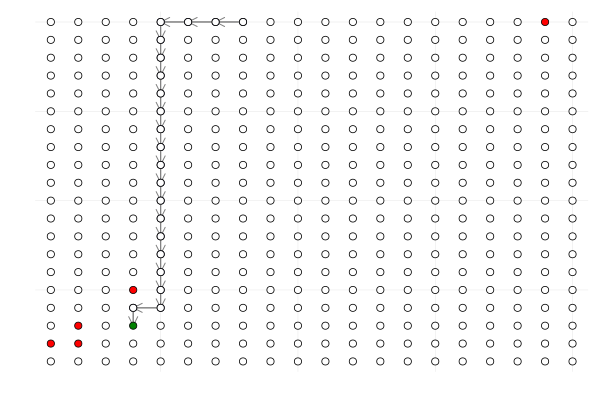

In [21]:
let
    # setup 
    world_model = world;
    is_reward_shaping_on = false;
   
    # draw the path -
    p = plot();
    initial_site = startstate
    hit_absorbing_state = false
    s = world_model.states[initial_site];
    visited_sites = Set{Tuple{Int,Int}}();
    push!(visited_sites, initial_site);

    s′ = s;
    while (hit_absorbing_state == false)
        
        current_position = world_model.coordinates[s′]
        a = my_π[s′];
        Δ = world_model.moves[a];
        new_position =  current_position .+ Δ
        scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, msc=:black, c=:blue)
        plot!([current_position[1], new_position[1]],[current_position[2],new_position[2]], label="", arrow=true, lw=1, c=:gray)

        s′ = nothing;
        if (in(new_position, absorbing_state_set) == true || in(new_position, visited_sites) == true)
            hit_absorbing_state = true;
        elseif (haskey(world_model.states, new_position) == true)
            s′ = world_model.states[new_position];
            push!(visited_sites, new_position);
        else
            hit_absorbing_state = true; 
        end
    end

    # draw the grid -
    for s ∈ 𝒮
        current_position = world_model.coordinates[s]
        a = my_π[s];
        Δ = world_model.moves[a];
        new_position =  current_position .+ Δ
        
         if (haskey(rewards, current_position) == true && rewards[current_position] == charging_reward)
            scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:green, ms=4)
        elseif (haskey(rewards, current_position) == true && rewards[current_position] == lava_reward)
            scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:red, ms=4)
        elseif (in(current_position, soft_wall_set) == true)
            scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:gray69, ms=4)
        else
            if (is_reward_shaping_on == true)
                new_color = weighted_color_mean(rbf(current_position, charging_station_coordinates, σ = σ), colorant"green", colorant"white")
                scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, msc=:black, c=new_color)
            else
                scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, msc=:black, c=:white)
            end
        end
    end
    current()
end

___


## Discussion: Extensions and Open Questions
Now that we have a working value iteration implementation, there are many interesting directions to explore that would deepen our understanding of MDPs and reinforcement learning:

> __Future Directions:__
> 1. **Impact of discount factor:** How does changing $\gamma$ affect the optimal policy? Try values like $\gamma = 0.5$ (myopic, prioritizes immediate rewards) versus $\gamma = 0.99$ (far-sighted, values long-term rewards). Do paths change? Does the robot take different routes?
> 
> 2. **Stochastic transitions:** Our current model has deterministic transitions where actions always succeed. What if we introduced uncertainty? For example, when the robot tries to move up, it could succeed 80% of the time but accidentally move left/right 10% each. How would this affect the optimal policy and path safety margins around lava pits?
> 
> 3. **Convergence speed:** How many iterations does value iteration require to converge for different grid sizes? Try 5×5, 10×10, and 40×40 grids. How does the number of iterations scale with state space size? What about different tolerance values $\epsilon$?
> 
> 4. **Multiple goals:** What happens if we add multiple charging stations at different locations with different rewards? Does the robot always choose the closest one, or does the path efficiency trade-off matter?
> 
> 5. **Continuous state spaces:** Our grid is discrete, but real robots operate in continuous space. How would you extend this approach to handle continuous positions and orientations? (Hint: look into function approximation and deep reinforcement learning)

These extensions connect to important topics in reinforcement learning, robotics, and optimal control. Feel free to experiment!
___

## Summary
In this example, we implemented the value iteration algorithm to solve a 20×20 grid world navigation task, computing the optimal policy for a robot to reach a charging station while avoiding lava pits from any starting position.

> __Key Takeaways:__
> 
> * **MDP formulation for spatial navigation:** We constructed a Markov Decision Process with 400 states representing grid positions, 4 directional movement actions, deterministic transition dynamics, and a reward structure balancing goal achievement (+100 for charging station), hazard avoidance (-1000 for lava pits), and path efficiency (-1 step cost), all discounted to prioritize reaching the goal quickly.
> * **Value iteration with Bellman updates:** We iteratively computed the optimal value function by applying the Bellman backup operation, which propagates utility values backward from high-reward states through the state space until convergence. This process evaluates the long-term value of every grid position by considering both immediate rewards and discounted future returns.
> * **Policy extraction and visualization:** We derived the optimal policy by computing action-value functions from the converged value function and selecting the best action at each state. Visualizing the resulting navigation paths showed how the robot optimally navigates from arbitrary starting positions to the charging station while circumventing hazards, demonstrating that value iteration produces rational goal-directed behavior.

Value iteration provides a principled approach to solving sequential decision problems by computing policies that maximize expected cumulative reward, with applications in robotics, autonomous systems, and resource allocation.
___